In [1]:
from HyperbolicGraphSimulation import HyperbolicGraphSimulation
import json
import random
import networkx as nx
import os
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.integrate as si
from IPython.display import clear_output
import time
from python_tsp.heuristics import solve_tsp_simulated_annealing, solve_tsp_lin_kernighan


In [2]:
from rpy2.robjects import r
import numpy as np

r('library(TSP)')
r.concorde_path("/home/woonam/concorde/TSP")

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


found: concorde concorde.c concorde.o 


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


'/home/woonam/concorde/TSP'


In [3]:
def plot_graph(G):
    """
    Plots the graph using matplotlib.
    
    Parameters:
        G (networkx.Graph): The graph to be plotted.
    """
    # Draw the graph
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title("Uniformly Sampled Graph")
    plt.show()

In [4]:
def calculate_mean_and_std(lists):
    """
    Find the mean and standard deviation when the number of elements in the list is not equal
    :param lists: input list
    :return: mean and standard deviation
    """
    # Find the Maximum Length
    max_len = max(len(lst) for lst in lists)

    # Add each list to the maximum length
    padded_lists = [lst + [0] * (max_len - len(lst)) for lst in lists]

    # Calculate the mean and standard deviation for each location of the lists
    means = np.mean(padded_lists, axis=0)
    stds = np.std(padded_lists, axis=0)

    return means, stds

In [5]:
def graph_to_distance_matrix(G):
    size = len(G)
    dist_matrix = np.zeros((size, size))
    for i, u in enumerate(G.nodes()):
        for j, v in enumerate(G.nodes()):
            if i != j:
                dist_matrix[i][j] = G[u][v]['weight'] if G.has_edge(u, v) else size * 10
    return dist_matrix

In [6]:
def average_degree(graph):
    """
    Calculates the average degree
    :param graph: input graph
    :return: average degree of graph
    """

    degree = sum(dict(graph.degree()).values()) / len(graph)

    return degree

In [7]:
def hyperbolic_graph_generator(n, k, alpha, radi):
    """
    Generate hyperbolic graph.
    :param n: The number of nodes of graph
    :param k: Average degree of nodes
    :param alpha: Negative curvature
    :return: Connected hyperbolic graph G
    """
    # set up simulator
    simulator = HyperbolicGraphSimulation()

    # generate graph
    G = simulator.generateGraph(n, k, alpha, radi)

    return G

In [8]:
def concorde_TSP_solver(mat):
    """
    Solve traveling salesman problem with concorde solver using R
    :param mat: input matrix
    :return: optimized tour length
    """
    r.assign('mat', mat)
    # change list data to matrix data
    r('Matrix_x <- matrix(unlist(mat), ncol = length(mat), byrow = TRUE)')
    # use concorde TSP solver
    r('tsp <- TSP(Matrix_x)')
    r('tour <- solve_TSP(tsp, "concorde")')
    # get tour length from solved data
    result = r('tour_length(tour)')

    return result

In [9]:
def weib(x, scale_param, shape_param):
    return (shape_param / scale_param) * (x / scale_param)**(shape_param - 1) * np.exp(-(x / scale_param)**shape_param)

def normalisation(x, scale_param, shape_param):
    return si.simps(weib(x, scale_param, shape_param), x)

class weibull(ss.rv_continuous):
    def _pdf(self, x, scale_param, shape_param):
        return weib(x, scale_param, shape_param)

def sample_within_range(samples, x):
    # 주어진 범위 내에 있는 값만 반환
    return np.clip(samples, x.min(), x.max())

def generate_weibull_graph(n, shape_param, scale_param, mink):
    x = np.linspace(0.0, n - 2, n)
    weibull_distribution = weibull(name="weibull_distribution", a=0.0)

    # 샘플링 후 주어진 범위 내에 있는 값만을 선택합니다.
    samples = sample_within_range(weibull_distribution.rvs(size=n, scale_param=scale_param, shape_param=shape_param), x)
    degrees = [int(element)+mink for element in samples]
    while not nx.is_graphical(degrees):
        samples = sample_within_range(
            weibull_distribution.rvs(size=n, scale_param=scale_param, shape_param=shape_param), x)
        degrees = [int(element)+mink for element in samples]
    degrees = list(degrees)
    G = nx.random_degree_sequence_graph(degrees, tries=100000)

    for (u, v, w) in G.edges(data=True):
        w['weight'] = random.randint(1, 10)

    return G

In [10]:
def distance_matrix_generator(num_cities, k, p):
    """
    Generate distance matrices that meets the given conditions
    :param num_cities: number of nodes in the graph
    :param average_k:
    :return: distance matrices and optimizing results of concorde solver
    """
    # mat[rewiring probabilities][trials]
    dist_matrix = []
    con_opt_result = []
    # Make 100 dataset
    while len(dist_matrix) < 10:
        # Generate graph satisfying constraints
        const = False
        while not const:
            const = False
            G = nx.connected_watts_strogatz_graph(num_cities, k, p)
            for (u, v, w) in G.edges(data=True):
                w['weight'] = random.randint(1, 10)
            distance_matrix = graph_to_distance_matrix(G)
            con_result = list(concorde_TSP_solver(distance_matrix.tolist()))[0]
            print(con_result)
            if con_result < num_cities * 10:
                const = True
        dist_matrix.append(distance_matrix.tolist())
        con_opt_result.append(con_result)


    return dist_matrix, con_opt_result

In [11]:
def generate_watts_dataset(n, k):
    """
    solve TSP
    :param n: problem size of TSP
    :param k: average_k
    :return:
    """
    con_list = []
    lk_list = []
    mat_list = []
    for p in [1, 0.1, 0.01, 0.001, 0.0001]:
        # generate graphs
        distance_matrix, con_result = distance_matrix_generator(n, k, p)

        lk_result = []
        for i in range(len(distance_matrix)):
            lk_res = []
            for iter in range(100):
                lk_opt, lk_distance = solve_tsp_lin_kernighan(np.array(distance_matrix[i]))
                lk_res.append(lk_distance)
            lk_result.append(lk_res)
        con_list.append(con_result)
        lk_list.append(lk_result)
        mat_list.append(distance_matrix)
    
    dataset = {'con_result': con_list, 'lk_result': lk_list, 'distance_matrix': mat_list}
    
    file_path = os.getcwd()
    
    file_name = f'watts_n{n}_k{k}'
    with open(f'{file_path}/dataset/TSP_dataset_{file_name}.json', 'w') as file:
        json.dump(dataset, file)

In [12]:
def regular_matrix_generator(num_cities, k):
    """
    Generate distance matrices that meets the given conditions
    :param num_cities: number of nodes in the graph
    :param average_k:
    :return: distance matrices and optimizing results of concorde solver
    """
    # mat[rewiring probabilities][trials]
    dist_matrix = []
    con_opt_result = []
    # Make 100 dataset
    while len(dist_matrix) < 100:
        # Generate graph satisfying constraints
        const = False
        while not const:
            const = False
            G = nx.random_regular_graph(k, num_cities)
            for (u, v, w) in G.edges(data=True):
                w['weight'] = random.randint(1, 10)
            distance_matrix = graph_to_distance_matrix(G)
            con_result = list(concorde_TSP_solver(distance_matrix.tolist()))[0]
            print(con_result)
            if con_result < num_cities * 10:
                const = True
        dist_matrix.append(distance_matrix.tolist())
        con_opt_result.append(con_result)


    return dist_matrix, con_opt_result

In [13]:
def generate_regular_dataset(n, k):
    """
    solve TSP
    :param n: problem size of TSP
    :param k: average_k
    :return:
    """
    con_list = []
    lk_list = []
    mat_list = []
    for p in [1]:
        # generate graphs
        distance_matrix, con_result = regular_matrix_generator(n, k)

        lk_result = []
        for i in range(len(distance_matrix)):
            lk_res = []
            for iter in range(100):
                lk_opt, lk_distance = solve_tsp_lin_kernighan(np.array(distance_matrix[i]))
                lk_res.append(lk_distance)
            lk_result.append(lk_res)
        con_list.append(con_result)
        lk_list.append(lk_result)
        mat_list.append(distance_matrix)
    
    dataset = {'con_result': con_list, 'lk_result': lk_list, 'distance_matrix': mat_list}
    
    file_path = os.getcwd()
    
    file_name = f'regular_n{n}_k{k}'
    with open(f'{file_path}/dataset/TSP_dataset_{file_name}.json', 'w') as file:
        json.dump(dataset, file)

In [14]:
def planer_matrix_generator(n):
    """
    Generate distance matrices that meets the given conditions
    :param num_cities: number of nodes in the graph
    :param average_k:
    :return: distance matrices and optimizing results of concorde solver
    """
    # mat[rewiring probabilities][trials]
    dist_matrix = []
    con_opt_result = []
    # Make 100 dataset
    while len(dist_matrix) < 10:
        # Generate graph satisfying constraints
        const = False
        while not const:
            const = False
            G = nx.dorogovtsev_goltsev_mendes_graph(n)
            for (u, v, w) in G.edges(data=True):
                w['weight'] = random.randint(1, 10)
            distance_matrix = graph_to_distance_matrix(G)
            con_result = list(concorde_TSP_solver(distance_matrix.tolist()))[0]
            print(con_result)
            if con_result < 3*(3**n+1)/2 * 10:
                const = True
        dist_matrix.append(distance_matrix.tolist())
        con_opt_result.append(con_result)


    return dist_matrix, con_opt_result

In [15]:
def generate_planar_dataset(n):
    """
    solve TSP
    :param n: problem size of TSP
    :param k: average_k
    :return:
    """
    con_list = []
    lk_list = []
    mat_list = []
    for p in [1]:
        # generate graphs
        distance_matrix, con_result = planer_matrix_generator(n)

        lk_result = []
        for i in range(len(distance_matrix)):
            lk_res = []
            for iter in range(100):
                lk_opt, lk_distance = solve_tsp_lin_kernighan(np.array(distance_matrix[i]))
                lk_res.append(lk_distance)
            lk_result.append(lk_res)
        con_list.append(con_result)
        lk_list.append(lk_result)
        mat_list.append(distance_matrix)
    
    dataset = {'con_result': con_list, 'lk_result': lk_list, 'distance_matrix': mat_list}
    
    file_path = os.getcwd()
    file_name = f'planar_n{n}'
    with open(f'{file_path}/dataset/TSP_dataset_{file_name}.json', 'w') as file:
        json.dump(dataset, file)

In [16]:
def graph_random_update(mat, con, n):
    nodes = list(range(n))
    distance_matrix = []
    con_result = []
    for p in [1, 0.1, 0.01]:
        mat_p = []
        con_p = []
        for i in range(len(mat)):
            mat_G = np.array(mat[i])
            mat_G[mat_G == n * 10] = 0
            G = nx.Graph(mat_G)
            const = False
            while not const:
                for j in range(1, k // 2 + 1):  # outer loop is neighbors
                    # inner loop in node order
                    edges = G.edges()
                    for edge in edges:
                        u, v = edge
                        if random.random() < p:
                            w = random.choice(nodes)
                            # Enforce no self-loops or multiple edges
                            while w == u or G.has_edge(u, w):
                                w = random.choice(nodes)
                                if G.degree(u) >= n - 1:
                                    break  # skip this rewiring
                            if np.abs(u-v) != 1 and np.abs(u-v) != n-1:
                                G.remove_edge(u, v)
                                G.add_edge(u, w)
                                
                for (u, v, w) in G.edges(data=True):
                    w['weight'] = random.randint(1, 10)
                mat_a = graph_to_distance_matrix(G)
                con_res = list(concorde_TSP_solver(mat_a.tolist()))[0]
                print(con_res)
                if con_res < n * 10:
                    const = True
            mat_p.append(mat_a.tolist())
            con_p.append(con_res)
        distance_matrix.append(mat_p)
        con_result.append(con_p)
    distance_matrix.append(mat)
    con_result.append(con)
    
    return distance_matrix, con_result

In [17]:
def plot_degree_distribution(G):
    """
    Plots the degree distribution of the graph as a histogram.
    
    Parameters:
        G (networkx.Graph): The graph whose degree distribution is to be plotted.
    """
    # Get the degrees of all nodes
    degrees = [deg for node, deg in G.degree()]
    
    # Plot the degree distribution
    plt.figure(figsize=(8, 4))
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), alpha=0.75, color='green', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    plt.xticks(range(min(degrees), max(degrees) + 1))
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

In [18]:
def count_occurrences(lst, k):
    """
    리스트에서 특정 숫자 k의 출현 횟수를 세는 함수

    Args:
    - lst (list): 숫자들이 담긴 리스트
    - k (int): 출현 횟수를 세고자 하는 숫자

    Returns:
    - count (int): k의 출현 횟수
    """
    count = 0
    for num in lst:
        if num == k:
            count += 1
    return count

In [19]:
def power_law_graph(n, k_min, alpha=1, k_max=None):
    if k_max == None:
        k_max = int(n/2)
    
    pmf = np.zeros(k_max - k_min + 1)
    for i in range(len(pmf)):
        pmf[i] = 1/((i+1)**alpha)
    pmf = pmf/np.sum(pmf)
    
    degree_distribution = np.zeros(len(pmf))
    for j in range(n):
        # Initialize cumulative probability
        cumulative_prob = 0
        rand_num = np.random.rand()
    
        # Iterate over PMF values and probabilities
        for k in range(len(pmf)):
            cumulative_prob += pmf[k]
            # If cumulative probability exceeds the random number, return the corresponding value
            if rand_num <= cumulative_prob:
                degree_distribution[k] = degree_distribution[k] + 1
                break
    
    degree_distribution = np.zeros(len(pmf))
    for i in range(len(pmf)):
        degree_distribution[i] = int(pmf[i]*n)
    G = nx.complete_graph(n)
    while max(dict(G.degree()).values()) > k_max:
        rand_edge = random.choice(list(G.edges()))
        if np.abs(rand_edge[0]-rand_edge[1]) != 1 and np.abs(rand_edge[0]-rand_edge[1]) != n-1:
            G.remove_edge(rand_edge[0], rand_edge[1])
    
    degree_distribution = list(reversed(degree_distribution))
    for l in range(len(degree_distribution)-1):
        num_k = degree_distribution[l]
        kk = k_max - l
        while count_occurrences(list(dict(G.degree()).values()), kk) > num_k:
            nodes_remove = [node for node, degree in G.degree() if degree == kk]
            node_to_remove1 = random.choice(nodes_remove)
            node_to_remove2 = random.choice(list(G.neighbors(node_to_remove1)))
            if np.abs(node_to_remove2 - node_to_remove1) != 1 and np.abs(node_to_remove2 - node_to_remove1) != n-1:
                G.remove_edge(node_to_remove1, node_to_remove2)
            
    return(G)

In [20]:
g = power_law_graph(400, 2)

In [27]:
def p_value_in_R(x_TSP):
    r('library("poweRlaw")')
    
    # convert data to R
    r.assign('x_TSP', x_TSP)
    r('x_TSP_re <- unlist(x_TSP)')
    r('names(x_TSP_re) <- names(x_TSP)')
    
    # fitting power-law
    r('m_pl <- displ$new(x_TSP_re)')
    r('est <- estimate_xmin(m_pl)')
    r('m_pl$setXmin(est)')
    r('bs_p = bootstrap_p(m_pl)')
    p_pl = r('bs_p$p')[0]
    
    '''# fitting log normal
    r('m_ln = dislnorm$new(x_TSP_re)')
    r('est = estimate_xmin(m_ln)')
    r('m_ln$setXmin(est)')
    r('bs_p = bootstrap_p(m_ln)')
    p_ln = r('bs_p$p')[0]'''
    
    # fitting poisson
    r('m_pois = dispois$new(x_TSP_re)')
    r('est = estimate_xmin(m_pois)')
    r('m_pois$setXmin(est)')
    r('bs_p = bootstrap_p(m_pois)')
    p_pois = r('bs_p$p')[0]
    
    """ # fitting exponential
    r('m_exp = disexp$new(x_TSP_re)')
    r('est = estimate_xmin(m_exp)')
    r('m_exp$setXmin(est)')
    r('bs_p = bootstrap_p(m_exp)')
    p_exp = r('bs_p$p')[0]"""
    
    return p_pl, 0, p_pois

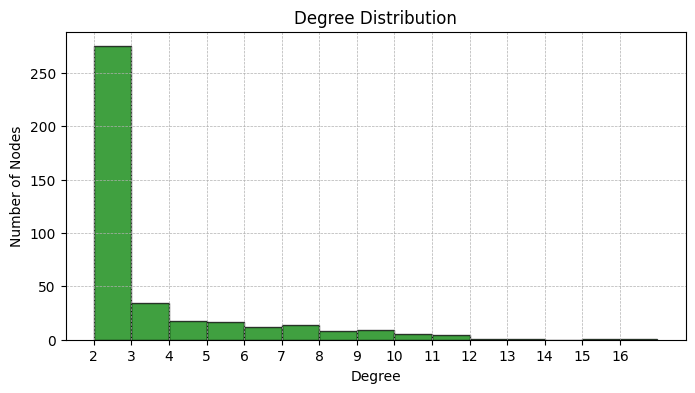

In [26]:
plot_degree_distribution(g)

In [28]:
p_pl, p_ln, p_pois = p_value_in_R(list(dict(g.degree()).values()))

R[write to console]: Expected total run time for 100 sims, using 1 threads is 5.7 seconds.

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 
R[write to console]: Expected total run time for 100 sims, using 1 threads is 1.69 seconds.

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


In [29]:
print(p_pl, p_pois)

0.97 0.48


In [21]:
def power_matrix_generator(n, k, alpha, max_k):
    """
    Generate distance matrices that meets the given conditions
    :param num_cities: number of nodes in the graph
    :param average_k:
    :return: distance matrices and optimizing results of concorde solver
    """
    # mat[rewiring probabilities][trials]
    dist_matrix = []
    con_opt_result = []
    # Make 100 dataset
    while len(dist_matrix) < 10:
        # Generate graph satisfying constraints
        const = False
        while not const:
            const = False
            G = power_law_graph(n, k, alpha=alpha, k_max=max_k)
            for (u, v, w) in G.edges(data=True):
                w['weight'] = random.randint(1, 10)
            distance_matrix = graph_to_distance_matrix(G)
            con_result = list(concorde_TSP_solver(distance_matrix.tolist()))[0]
            print(con_result)
            if con_result < n * 10:
                const = True
        dist_matrix.append(distance_matrix.tolist())
        con_opt_result.append(con_result)


    return dist_matrix, con_opt_result

In [22]:
def generate_power_dataset(n, k, alpha, max_k):
    """
    solve TSP
    :param n: problem size of TSP
    :param k: average_k
    :return:
    """
    lk_list = []
    
    # generate graphs
    distance_matrix, con_result = power_matrix_generator(n, k, alpha, max_k)
    mat_list, con_list = graph_random_update(distance_matrix, con_result, n)
    
    for p in range(len(mat_list)):
        lk_result = []
        for i in range(len(mat_list[p])):
            lk_res = []
            for iter in range(100):
                lk_opt, lk_distance = solve_tsp_lin_kernighan(np.array(mat_list[p][i]))
                lk_res.append(lk_distance)
            lk_result.append(lk_res)
        lk_list.append(lk_result)
    """lk_result = []
    for i in range(len(distance_matrix)):
        lk_res = []
        for iter in range(100):
            lk_opt, lk_distance = solve_tsp_lin_kernighan(np.array(distance_matrix[i]))
            lk_res.append(lk_distance)
        lk_result.append(lk_res)"""
    
    dataset = {'con_result': con_list, 'lk_result': lk_list, 'distance_matrix': mat_list}
    
    file_path = os.getcwd()
    file_name = f'power_n{n}_k{k}'
    with open(f'{file_path}/dataset/TSP_dataset_{file_name}.json', 'w') as file:
        json.dump(dataset, file)

In [23]:
def generate_lk(dataset1):
    """
    solve TSP
    :param n: problem size of TSP
    :param k: average_k
    :return:
    """
    lk_list = []
    
    # generate graphs
    mat_list = dataset1['distance_matrix']
    con_list = dataset1['con_result']
    
    for p in range(len(mat_list)):
        lk_result = []
        for i in range(len(mat_list[p])):
            lk_res = []
            for iter in range(100):
                lk_opt, lk_distance = solve_tsp_lin_kernighan(np.array(mat_list[p][i]))
                lk_res.append(lk_distance)
            lk_result.append(lk_res)
        lk_list.append(lk_result)
    """lk_result = []
    for i in range(len(distance_matrix)):
        lk_res = []
        for iter in range(100):
            lk_opt, lk_distance = solve_tsp_lin_kernighan(np.array(distance_matrix[i]))
            lk_res.append(lk_distance)
        lk_result.append(lk_res)"""
    
    dataset = {'con_result': con_list, 'lk_result': lk_list, 'distance_matrix': mat_list}
    
    file_path = os.getcwd()
    file_name = f'power_n{n}_k{k}'
    with open(f'{file_path}/dataset/TSP_dataset_{file_name}_1.json', 'w') as file:
        json.dump(dataset, file)

In [147]:
for n in range(2, 6):
    for nn in range(1, 10):
        for k in [5, 7]:
            generate_watts_dataset(n*10+nn, k)
            clear_output()

In [24]:
for n in [100, 200, 400]:
    for k in [4, 5, 6, 7]:
        generate_watts_dataset(n, k)
        clear_output()

In [19]:
for n in [40]:
    for k in [6, 8, 10, 12, 14, 18, 20]:
        generate_watts_dataset(n, k)
        clear_output()

In [21]:
for n in [60]:
    for k in [6, 8, 10, 12, 14, 16, 18, 20]:
        generate_watts_dataset(n, k)
        clear_output()

In [20]:
for n in [20, 40, 60]:
    for k in [4, 6]:
        generate_regular_dataset(n, k)
        clear_output()
    for k5 in [2, 3, 4]:
        generate_regular_dataset(n, int(n*k5/5))
        clear_output()

In [107]:
file_path = os.getcwd()

In [108]:
for n, k, alpha in [(20, 4, 1.5), (20, 6, 1.5), (40, 4, 2), (40, 8, 1.9), (40, 12, 1.9), (60, 4, 2.3), (60, 12, 2), (60, 18, 2)]:
    file_name = f'{file_path}/dataset/TSP_dataset_power_n{n}_k{k}.json'
    with open(file_name, 'r') as file:
        dataset = json.load(file)
    generate_lk(dataset)
    clear_output()

In [141]:
for n, k, alpha in [(20, 3, 1.5), (20, 5, 1.5), (40, 3, 2), (40, 5, 2), (40, 6, 2), (60, 3, 2), (60, 5, 2), (60, 6, 2)]:
    generate_power_dataset(n, k, alpha, n-1)
    clear_output()

In [142]:
for n in range(20, 61):
    for k in [3, 4, 5, 6]:
        generate_power_dataset(n, k, 1.5, n-1)
        clear_output()

In [145]:
g = nx.connected_watts_strogatz_graph(20, 3, 1)
average_degree(g)

6.0

In [ ]:
"""nn = [5]
for n in nn:
    generate_planar_dataset(n)"""
"""unable solve TSP"""